In [1]:
from src.common import *
from src.houses import *
from src.agents import *
from src.bidding import *
from src.sim import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker # to remove 1e6 base from the x axis on plots

In [2]:
agents, houses, stats, last_round = sim_one_round(n_agents=10_000, happiness_percent=0.99, converge=True)

Round 0
Happiness: 11.080%
Homelessness: 0.000%

Round 1
Happiness: 8.970%
Homelessness: 12.550%

Round 2
Happiness: 8.970%
Homelessness: 12.550%

Round 3
Happiness: 4.520%
Homelessness: 17.560%

Round 4
Happiness: 7.620%
Homelessness: 20.760%

Round 5
Happiness: 4.730%
Homelessness: 23.980%

Round 6
Happiness: 8.960%
Homelessness: 27.390%

Round 7
Happiness: 5.170%
Homelessness: 31.330%

Round 8
Happiness: 8.080%
Homelessness: 35.580%

Round 9
Happiness: 4.540%
Homelessness: 40.120%

Round 10
Happiness: 6.910%
Homelessness: 44.520%

Round 11
Happiness: 5.220%
Homelessness: 48.660%

Round 12
Happiness: 7.110%
Homelessness: 52.590%

Round 13
Happiness: 4.820%
Homelessness: 56.660%

Round 14
Happiness: 6.810%
Homelessness: 59.940%

Round 15
Happiness: 4.320%
Homelessness: 63.250%

Round 16
Happiness: 6.280%
Homelessness: 65.580%

Round 17
Happiness: 6.780%
Homelessness: 65.930%

Round 18
Happiness: 5.720%
Homelessness: 66.000%

Round 19
Happiness: 6.410%
Homelessness: 66.320%

Round 20
H

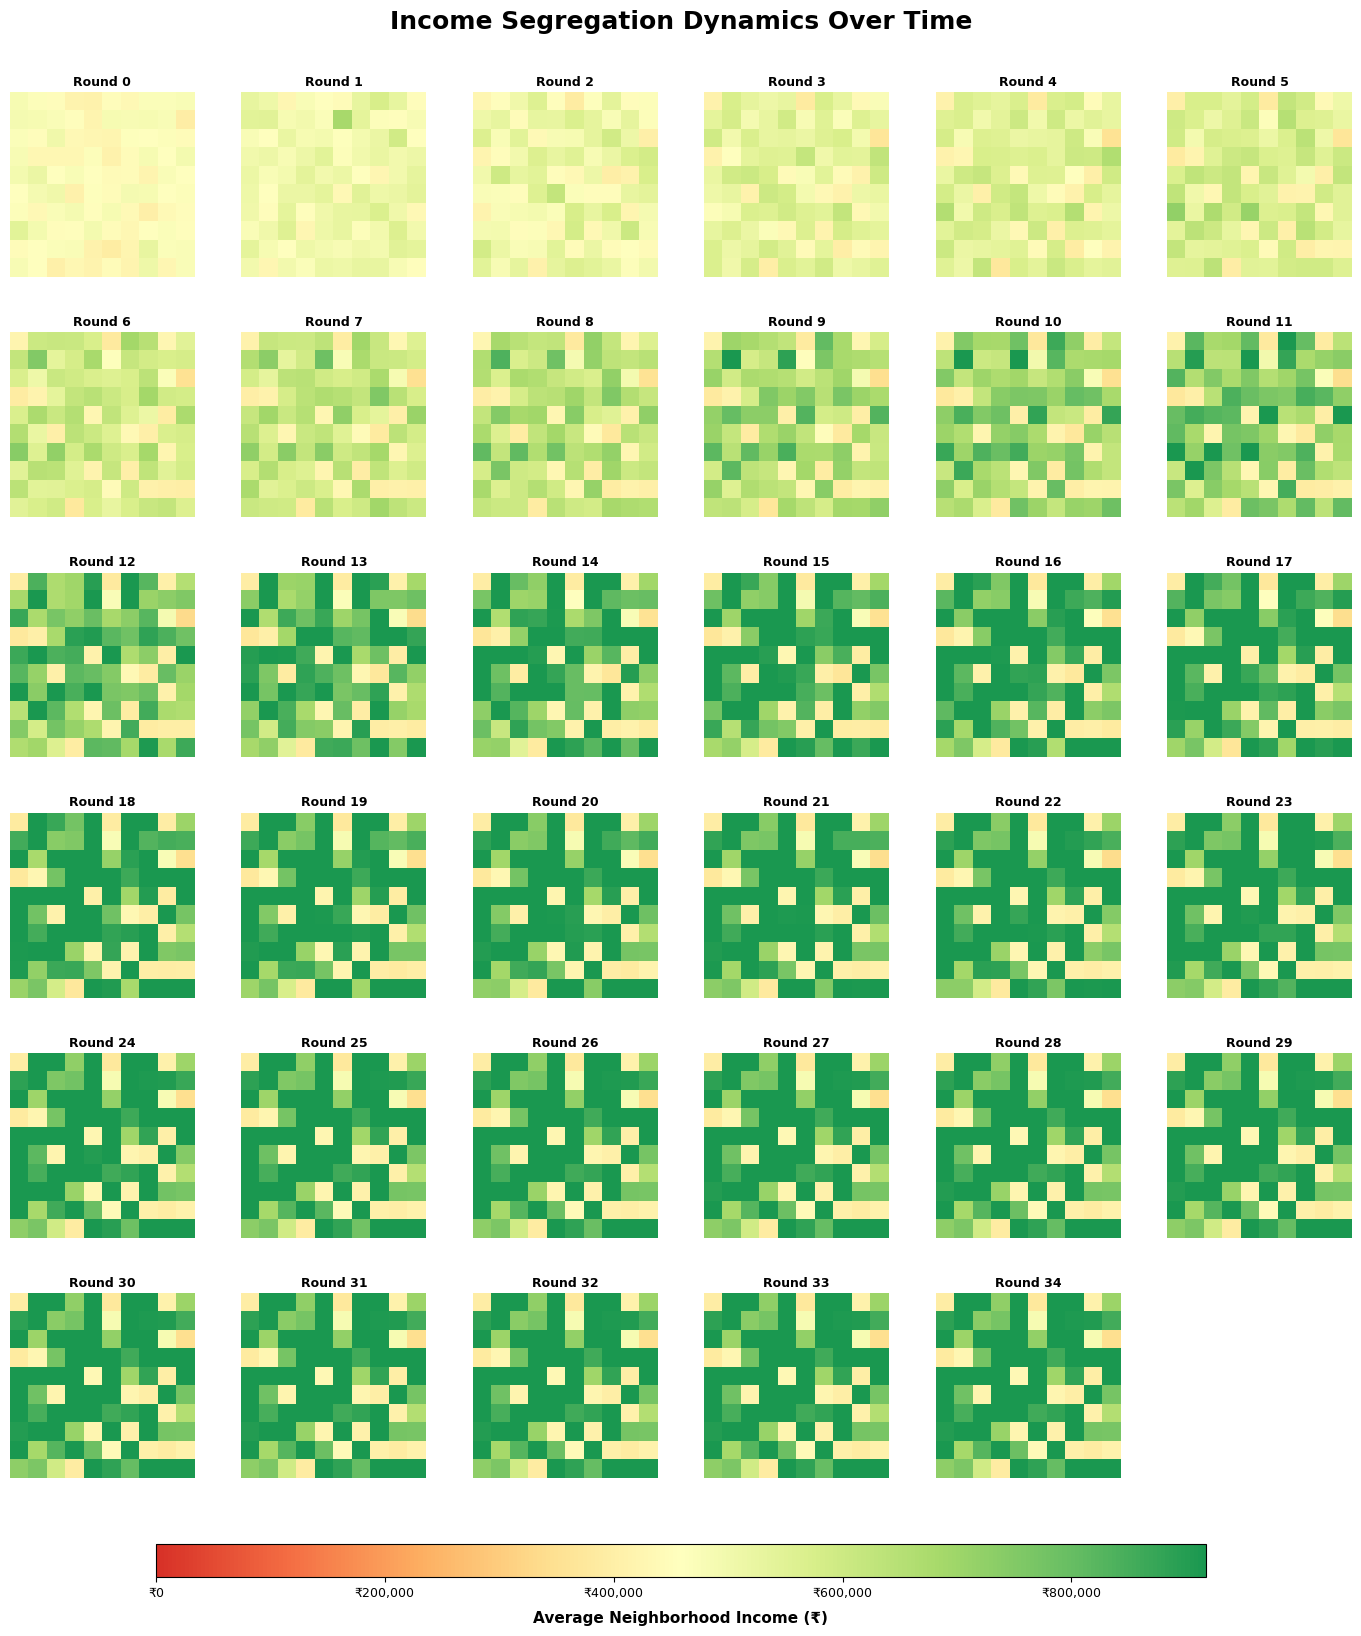

In [3]:
# visualize the segregation taking place
plot_segregation_grid(stats, last_round)

In [4]:
# makes the above into a gif
create_segregation_animation(stats, last_round)

Animation saved to segregation_animation.gif


In [5]:
# checking bookkeeping, theres still a very very tiny error for some agents (~0.006% error for 1M agents, idk why though)
no_house = np.sum(agents["house"]==-1)
no_tenant = np.sum(houses["tenant"]==-1)
homeless = np.sum(agents["neighborhood"]==-1)
happy = np.sum(agents["happy"])
print(f"Agents with no house: {no_house}")
print(f"Houses with no tenants: {no_tenant}")
print(f"Homeless agents (neighborhood = -1): {homeless}")
print(f"Happy agents: {happy}")

Agents with no house: 6730
Houses with no tenants: 0
Homeless agents (neighborhood = -1): 6730
Happy agents: 777


Final average house value: 275519.438


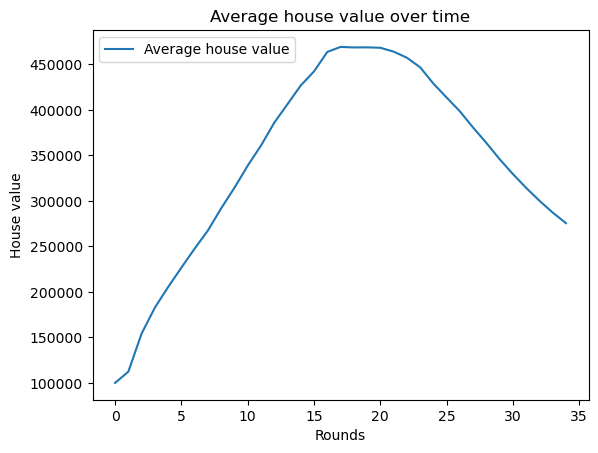

In [6]:
index = np.arange(0, last_round+1)
print(f"Final average house value: {stats["avg_value"][last_round]:.3f}")
plt.plot(index, stats["avg_value"][:last_round+1], label = "Average house value")
plt.legend()
plt.title("Average house value over time")
plt.xlabel("Rounds")
plt.ylabel("House value")
plt.show()

Avg churn: 2.937%


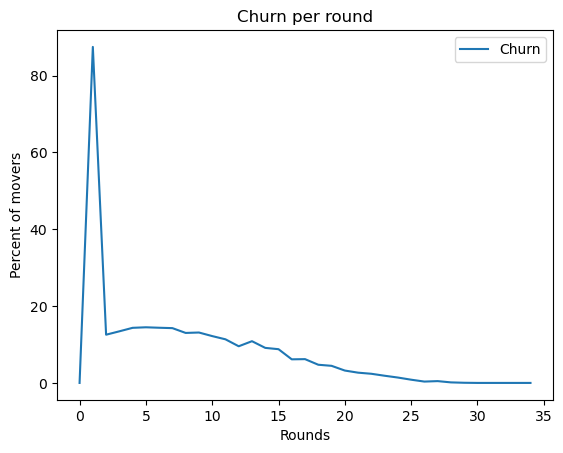

In [7]:
index = np.arange(0, last_round+1)
print(f"Avg churn: {np.mean(stats["churn"]):.3f}%")
plt.plot(index, stats["churn"][:last_round+1], label = "Churn")
plt.legend()
plt.title("Churn per round")
plt.xlabel("Rounds")
plt.ylabel("Percent of movers")
plt.show()

Final Gini: 9.735


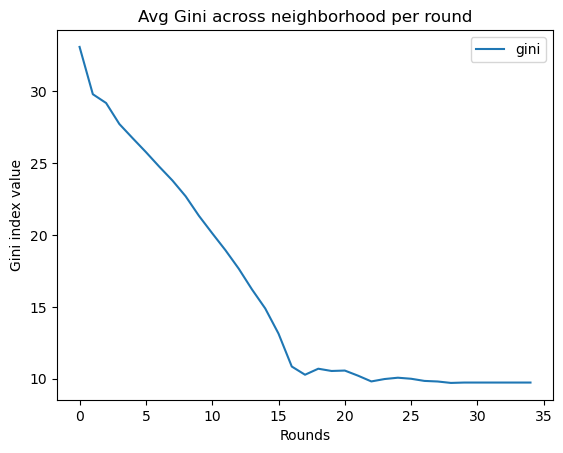

In [8]:
index = np.arange(0, last_round+1)
print(f"Final Gini: {stats["gini"][last_round]:.3f}")
plt.plot(index, stats["gini"][:last_round+1], label = "gini")
plt.legend()
plt.title("Avg Gini across neighborhood per round")
plt.xlabel("Rounds")
plt.ylabel("Gini index value")
plt.show()
# avg gini falls => more homogeneity within each neighborhood because of segregation

Final Theil: 0.024
Final Theil within: 0.014
Final Theil between: 0.258
Final global Theil: 0.272 = Theil within + Theil between


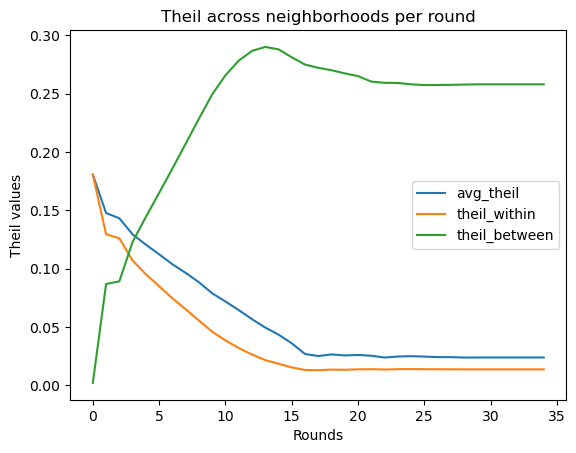

In [9]:
index = np.arange(0, last_round+1)
print(f"Final Theil: {stats["theil"][last_round]:.3f}")
print(f"Final Theil within: {stats["theil_within"][last_round]:.3f}")
print(f"Final Theil between: {stats["theil_between"][last_round]:.3f}")
print(f"Final global Theil: {stats["theil_within"][last_round]+stats["theil_between"][last_round]:.3f} = Theil within + Theil between")

plt.plot(index, stats["theil"][:last_round+1], label = "avg_theil")
plt.plot(index, stats["theil_within"][:last_round+1], label = "theil_within")
plt.plot(index, stats["theil_between"][:last_round+1], label = "theil_between")

plt.legend()
plt.title("Theil across neighborhoods per round")
plt.xlabel("Rounds")
plt.ylabel("Theil values")
plt.show()
# theil within falls -> neighborhoods become more homogenous
# theil between rises -> increased inequality between neighborhoods
# => segregation

Final homelessness: 67.300%


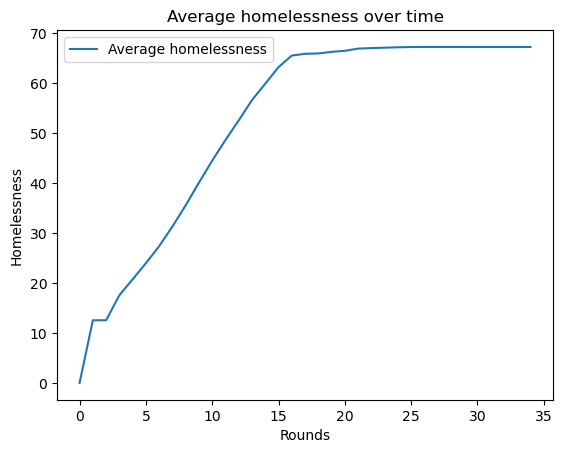

In [10]:
index = np.arange(0, last_round+1)
print(f"Final homelessness: {stats["homelessness"][last_round]:.3f}%")
plt.plot(index, stats["homelessness"][:last_round+1], label = "Average homelessness")
plt.legend()
plt.title("Average homelessness over time")
plt.xlabel("Rounds")
plt.ylabel("Homelessness")
plt.show()

Final happiness: 7.770%


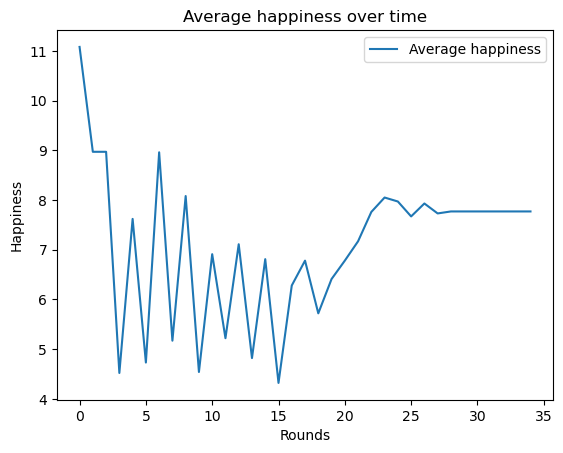

In [11]:
index = np.arange(0, last_round+1)
print(f"Final happiness: {stats["happiness"][last_round]:.3f}%")
plt.plot(index, stats["happiness"][:last_round+1], label = "Average happiness")
plt.legend()
plt.title("Average happiness over time")
plt.xlabel("Rounds")
plt.ylabel("Happiness")
plt.show()

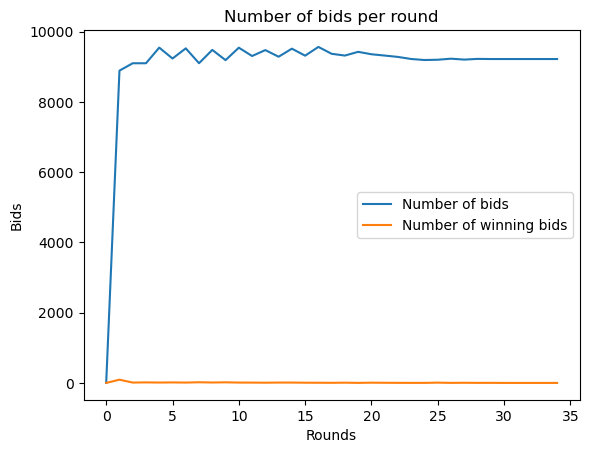

In [12]:
index = np.arange(0, last_round+1)
plt.plot(index, stats["num_bids"][:last_round+1], label = "Number of bids")
plt.plot(index, stats["winning_bids"][:last_round+1], label = "Number of winning bids")
plt.legend()
plt.title("Number of bids per round")
plt.xlabel("Rounds")
plt.ylabel("Bids")
plt.show()

Line of best fit (linear): y = 0.3051x + 27822.8422
correlation coefficient (linear): 0.4075

Line of best fit (log): y = -1.6004x + 30.8333
correlation coefficient (log): -0.1285


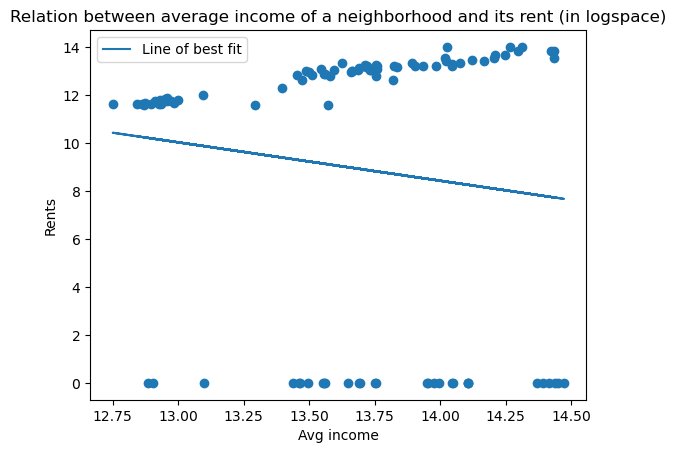

In [13]:
# plot the correlation between avg neighborhood income and the rent there
# you may need to change the size of these arrays
avg_income = np.zeros(N_NEIGHBORHOODS)
rent = np.zeros(N_NEIGHBORHOODS) # all houses in a neighborhood share the same price, so avg is meaningless

for i in range(N_NEIGHBORHOODS):
    agent_mask = agents["neighborhood"] == i
    if len(agent_mask) > 0:
        avg_income[i] = np.mean(agents["income"][agent_mask])
        if rent[i] == 0:
            valid = agents["rent_paid"][agent_mask]
            rent[i] = valid[0]
    else:
        avg_income[i] = 0
    
log_income = np.log(avg_income)
log_rent = np.zeros_like(log_income)
for i in range(len(rent)):
    if rent[i] > 0:
        log_rent[i] = np.log(rent[i])
    else:
        log_rent[i] = 0

m_linear, b_linear = np.polyfit(avg_income, rent,1)
correlation_linear = np.corrcoef(avg_income, rent)[0,1]
m,b = np.polyfit(log_income, log_rent, 1) # m here -> income elasticity of demand for housing
correlation = np.corrcoef(log_income, log_rent)[0,1]
print(f"Line of best fit (linear): y = {m_linear:.4f}x + {b_linear:.4f}")
print(f"correlation coefficient (linear): {correlation_linear:.4f}")
print()
print(f"Line of best fit (log): y = {m:.4f}x + {b:.4f}")
print(f"correlation coefficient (log): {correlation:.4f}")
plt.scatter(log_income, log_rent)
plt.plot(log_income, m*log_income+b, label = "Line of best fit")
plt.title("Relation between average income of a neighborhood and its rent (in logspace)")
plt.xlabel("Avg income")
plt.ylabel("Rents")
plt.legend()
plt.show()

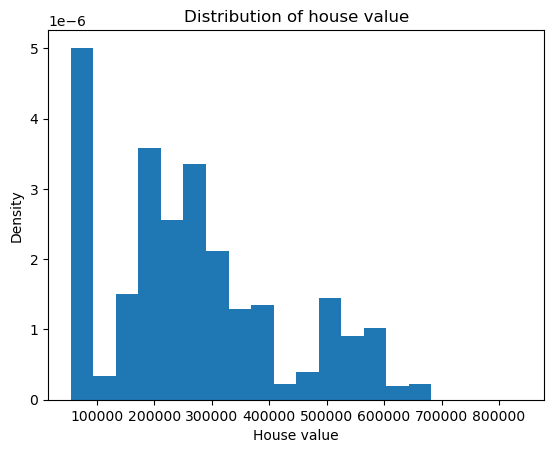

In [14]:
value = houses["value"]
plt.hist(value, bins = 20, density = True)
plt.xlabel("House value")
plt.ylabel("Density")
plt.title("Distribution of house value")
plt.show()

In [31]:
"""def run_sim(n, max_iter=100):
    # initialize agents and houses fresh each run
    agents = generate_agents(n)
    houses = initialize_houses(agents)
    
    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)

    priced_out_mask = check_priced_out(agents, houses, proportions)
    evict_priced_out(agents, houses, priced_out_mask)
    current_rents = get_current_rents(houses)

    utilities = get_utilities(agents, proportions,current_rents)
    bids, neighborhoods_chosen = place_bid(agents, utilities)
    agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
    houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)

    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)
    agents = check_happiness(agents, proportions)

    count = 1
    while not np.all(agents["happy"]):
        freq, total = get_freq_and_total(agents)
        proportions = get_proportion(freq, total)

        priced_out_mask = check_priced_out(agents, houses, proportions)
        evict_priced_out(agents, houses, priced_out_mask)
        current_rents = get_current_rents(houses)

        utilities = get_utilities(agents, proportions, current_rents)
        bids, neighborhoods_chosen = place_bid(agents, utilities)
        agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
        houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)
        
        freq, total = get_freq_and_total(agents)
        proportions = get_proportion(freq, total)
        agents = check_happiness(agents, proportions)

        count += 1
        if count >= max_iter:
            break
    
    # collect final stats
    happiness = np.mean(agents["happy"]) * 100
    homelessness = np.sum(agents["neighborhood"] == -1) * 100 / n
    return happiness, homelessness

# Monte Carlo loop
n = 10_000
runs = 30
results = [run_sim(n) for _ in range(runs)]

happiness_vals, homelessness_vals = zip(*results)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(happiness_vals, bins=10, edgecolor="black")
plt.xlabel("Final Happiness (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Happiness (30 runs)")

plt.subplot(1,2,2)
plt.hist(homelessness_vals, bins=10, edgecolor="black")
plt.xlabel("Final Homelessness (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Homelessness (30 runs)")

plt.tight_layout()
plt.show()"""

# first run: 76m 18.7s = 4578.7s
# after skipping utility check for happy agents: 71m 16.6s = 4276.6s (~6.6% speedup)

'def run_sim(n, max_iter=100):\n    # initialize agents and houses fresh each run\n    agents = generate_agents(n)\n    houses = initialize_houses(agents)\n\n    freq, total = get_freq_and_total(agents)\n    proportions = get_proportion(freq, total)\n\n    priced_out_mask = check_priced_out(agents, houses, proportions)\n    evict_priced_out(agents, houses, priced_out_mask)\n    current_rents = get_current_rents(houses)\n\n    utilities = get_utilities(agents, proportions,current_rents)\n    bids, neighborhoods_chosen = place_bid(agents, utilities)\n    agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)\n    houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)\n\n    freq, total = get_freq_and_total(agents)\n    proportions = get_proportion(freq, total)\n    agents = check_happiness(agents, proportions)\n\n    count = 1\n    while not np.all(agents["happy"]):\n        freq, total = get_freq_and_total(agents)\n        proportions = get_

In [32]:
no_house = np.sum(agents["house"]==-1)
no_tenant = np.sum(houses["tenant"]==-1)
homeless = np.sum(agents["neighborhood"]==-1)
happy = np.sum(agents["happy"])
print(f"Agents with no house: {no_house}")
print(f"Houses with no tenants: {no_tenant}")
print(f"Homeless agents (neighborhood = -1): {homeless}")
print(f"Happy agents: {happy}")

Agents with no house: 89945
Houses with no tenants: 0
Homeless agents (neighborhood = -1): 89945
Happy agents: 7573


Line of best fit (linear): y = 0.4080x + -137701.2888
correlation coefficient (linear): 0.3292

Line of best fit (log): y = 4.2751x + -51.5242
correlation coefficient (log): 0.1646


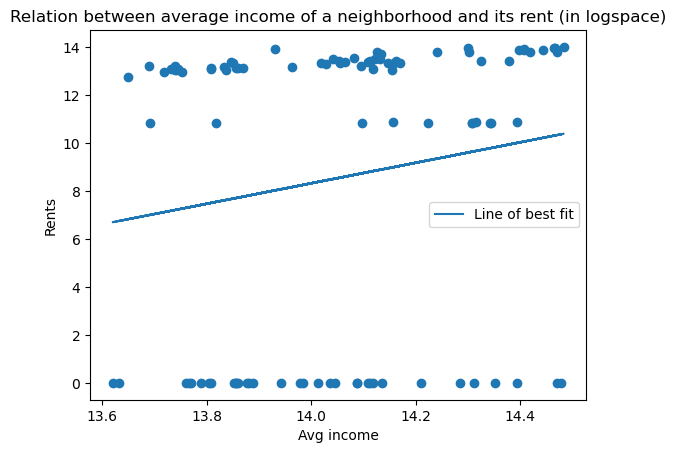

In [33]:
# plot the correlation between avg neighborhood income and the rent there
avg_income = np.zeros(N_NEIGHBORHOODS)
rent = np.zeros(N_NEIGHBORHOODS) # all houses in a neighborhood share the same price, so avg is meaningless

for i in range(N_NEIGHBORHOODS):
    agent_mask = agents["neighborhood"] == i
    if len(agent_mask) > 0:
        avg_income[i] = np.mean(agents["income"][agent_mask])
        if rent[i] == 0:
            valid = agents["rent_paid"][agent_mask]
            rent[i] = valid[0]
    else:
        avg_income[i] = 0
    
log_income = np.log(avg_income)
log_rent = np.zeros_like(log_income)
for i in range(len(rent)):
    if rent[i] > 0:
        log_rent[i] = np.log(rent[i])
    else:
        log_rent[i] = 0

m_linear, b_linear = np.polyfit(avg_income, rent,1)
correlation_linear = np.corrcoef(avg_income, rent)[0,1]
m,b = np.polyfit(log_income, log_rent, 1) # m here -> income elasticity of demand for housing
correlation = np.corrcoef(log_income, log_rent)[0,1]
print(f"Line of best fit (linear): y = {m_linear:.4f}x + {b_linear:.4f}")
print(f"correlation coefficient (linear): {correlation_linear:.4f}")
print()
print(f"Line of best fit (log): y = {m:.4f}x + {b:.4f}")
print(f"correlation coefficient (log): {correlation:.4f}")
plt.scatter(log_income, log_rent)
plt.plot(log_income, m*log_income+b, label = "Line of best fit")
plt.title("Relation between average income of a neighborhood and its rent (in logspace)")
plt.xlabel("Avg income")
plt.ylabel("Rents")
plt.legend()
plt.show()

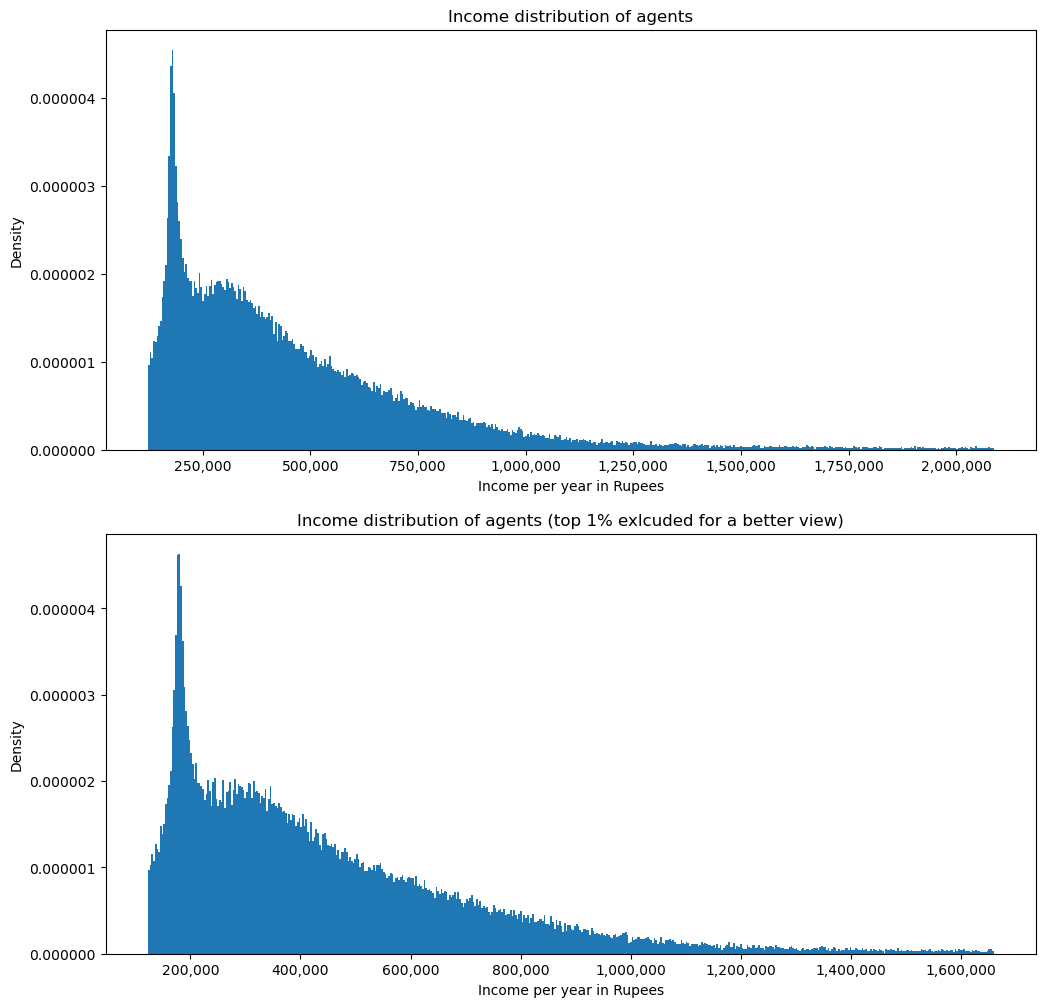

In [34]:
# plot the agents income distribution
incomes = agents["income"]

# Cut off at, say, the 99th percentile for visualization
cutoff = np.percentile(incomes, 99.0)
incomes_percentile = incomes[incomes <= cutoff]

fig, axes = plt.subplots(2,1,figsize = (12,12)) # one plot for actual income distr, one with top 1% cut off
axes[0].hist(incomes, bins = 500, density = True)
axes[0].set_title("Income distribution of agents")
axes[0].set_xlabel("Income per year in Rupees")
axes[0].set_ylabel("Density")
# format x-axis numbers with commas
axes[0].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:f}'))


# with top 1% cut off
axes[1].hist(incomes_percentile, bins = 500, density = True)
axes[1].set_title("Income distribution of agents (top 1% exlcuded for a better view)")
axes[1].set_xlabel("Income per year in Rupees")
axes[1].set_ylabel("Density")
axes[1].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:f}'))

plt.show()